In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import mutual_info_regression
from torch.optim.lr_scheduler import CyclicLR
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
torch.manual_seed(42)

In [9]:
# Configuração do dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cpu


In [10]:
# 1. Carregamento e Pré-processamento Avançado
try:
    df = pd.read_csv('walmart_sales.csv')
    
    # Converter datas
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
    
    # Remover outliers extremos
    q1 = df['Weekly_Sales'].quantile(0.05)
    q3 = df['Weekly_Sales'].quantile(0.95)
    df = df[(df['Weekly_Sales'] >= q1) & (df['Weekly_Sales'] <= q3)]
    
    # Feature engineering avançado
    df['Year'] = df['Date'].dt.year
    df['Days_to_Holiday'] = (df['Date'] - pd.to_datetime('2010-12-31')).dt.days.abs()
    df['Sales_Lag_4'] = df.groupby(['Store'])['Weekly_Sales'].shift(4)
    df['Temp_Fuel_Interaction'] = df['Temperature'] * df['Fuel_Price']
    df['Rolling_Avg_8'] = df.groupby('Store')['Weekly_Sales'].transform(
        lambda x: x.rolling(8, min_periods=1).mean()
    )
    df['Holiday_Impact'] = df['Holiday_Flag'] * df['Days_to_Holiday']
    
    # Preencher valores NaN
    df['Sales_Lag_4'] = df['Sales_Lag_4'].fillna(method='bfill')
    
    # Transformação logarítmica das vendas
    df['Weekly_Sales_Log'] = np.log1p(df['Weekly_Sales'])
    target = 'Weekly_Sales_Log'
    
    # Seleção de features baseada em mutual information
    features = [
        'Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
        'CPI', 'Unemployment', 'Year', 'Days_to_Holiday',
        'Sales_Lag_4', 'Temp_Fuel_Interaction', 'Rolling_Avg_8', 'Holiday_Impact'
    ]
    mi = mutual_info_regression(df[features], df[target])
    selected_features = [features[i] for i in np.where(mi > 0.01)[0]]
    
    # Normalização robusta
    scaler_feat = RobustScaler(quantile_range=(5, 95))
    scaler_target = RobustScaler()
    
    df[selected_features] = scaler_feat.fit_transform(df[selected_features])
    df[target] = scaler_target.fit_transform(df[[target]])

except FileNotFoundError:
    print("Erro: Arquivo 'walmart_sales.csv' não encontrado.")
    exit()

### 2. Preparação de Sequências Temporais

Aqui, preparamos as sequências temporais que serão usadas para treinar o modelo.

#### **O Que Está Sendo Feito?**
1. **Criação de Sequências**:
   - Criamos janelas temporais de `seq_length` semanas para prever `pred_length` semanas à frente.
   - Cada sequência contém as features e o target correspondente.

2. **Divisão dos Dados**:
   - Dividimos os dados em conjuntos de treino (80%) e teste (20%) de forma temporal para evitar vazamento de dados.

3. **Conversão para Tensores**:
   - Convertemos os dados para tensores do PyTorch e os enviamos para o dispositivo (CPU ou GPU).

#### **Por Que Essas Escolhas?**
- **Janelas Temporais**: Permitem que o modelo aprenda padrões sequenciais nas vendas.
- **Divisão Temporal**: Garante que o modelo seja avaliado em dados futuros, simulando um cenário real.
- **Tensores**: O PyTorch requer que os dados estejam no formato de tensores para o treinamento.

In [11]:
#2. Preparação de Sequências Temporais

def create_sequences(data, seq_length, pred_length):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length, -1])
    return np.array(X), np.array(y)

seq_length = 12  # Janela de 12 semanas
pred_length = 3   # Prever 3 semanas

X, y = create_sequences(df[selected_features + [target]].values, seq_length, pred_length)

# Divisão temporal
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Converter para tensores
X_train = torch.FloatTensor(X_train[:, :, :-1]).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test[:, :, :-1]).to(device)
y_test = torch.FloatTensor(y_test).to(device)

### 3. Arquitetura Transformer Aprimorada

Aqui, foi definida a arquitetura do modelo, que combina Transformer e LSTM.
#### **O Que Está Sendo Feito?**
1. **Embedding**:
   - As features são projetadas em um espaço de dimensionalidade maior (`hidden_dim`) para capturar relações complexas.
   - A projeção é dada por:
     $$
     \mathbf{E} = \mathbf{X} \mathbf{W}_e + \mathbf{b}_e$$
   - Onde $$\mathbf{X}$$ são as features de entrada, $$\mathbf{W}_e$$ é a matriz de pesos e $$\mathbf{b}_e$$ é o viés.

2. **Multihead Attention**:
   - Foi atenção multi-head para capturar dependências temporais entre as semanas.
   - A atenção é calculada como:
     $$
     \text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right) V
     $$
   - Onde \( Q \), \( K \) e \( V \) são as matrizes de consulta, chave e valor, respectivamente.

3. **LSTM**:
   - Adicionei uma camada LSTM para capturar padrões de longo prazo nas sequências temporais.
   - As equações do LSTM são:
     \
     \begin{aligned}
     f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \\
     i_t &= \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
     \tilde{C}_t &= \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) \\
     C_t &= f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t \\
     o_t &= \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\
     h_t &= o_t \cdot \tanh(C_t)
     \end{aligned}
     

4. **Camada de Saída**:
   - A saída do LSTM é passada por uma camada linear para gerar as previsões.
   - A previsão é dada por:
     $$hat{y} = \mathbf{W}_o \mathbf{h}_T + \mathbf{b}_o$$
   - Onde $$\mathbf{h}_T$$é o estado oculto final do LSTM.

In [12]:
# 3. Arquitetura Transformer Aprimorada
class EnhancedTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_heads=16):
        super().__init__()
        self.embed = nn.Linear(input_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim//2, batch_first=True, dropout=0.2)
        self.output = nn.Linear(hidden_dim//2, pred_length)

    def forward(self, x):
        x = self.embed(x)
        attn_out, _ = self.attention(x, x, x)
        lstm_out, _ = self.lstm(attn_out)
        return self.output(lstm_out[:, -1])

model = EnhancedTransformer(
    input_dim=len(selected_features),
    hidden_dim=512,
    num_heads=16
).to(device)

### 4. Treinamento com Configuração Otimizada

Aqui, configurei o treinamento do modelo com técnicas avançadas para melhorar a convergência.

#### **O Que Está Sendo Feito?**
1. **Otimizador AdamW**:
   - Foi utilizado AdamW com weight decay para regularização.
   - A atualização dos pesos é dada por:
     $$\mathbf{w}_{t+1} = \mathbf{w}_t - \eta \left( \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} + \lambda \mathbf{w}_t \right)$$
   - Onde:
     - $$\eta$$ é o learning rate.
     - $$\lambda$$ é o weight decay.
     - $$\hat{m}_t$$ e $$\hat{v}_t$$ são estimativas de primeiro e segundo momento.

2. **Agendador de Taxa de Aprendizado Cíclico**:
   - O learning rate varia ciclicamente para evitar estagnação durante o treinamento.
   - A taxa de aprendizado é dada por:
     $$\eta_t = \eta_{\text{min}} + \frac{1}{2} (\eta_{\text{max}} - \eta_{\text{min}}) (1 + \cos(\pi \cdot \text{mod}(t, T) / T))
     $$
   - Onde:
     - $$T$$é o período do ciclo.
     - $$\eta_{\text{min}}$$ e $$\eta_{\text{max}}$$ são os limites inferior e superior do learning rate.

3. **Função de Perda Huber**:
   - Combina as vantagens do MAE e MSE, sendo menos sensível a outliers.
   - A perda é dada por:
     $$
     L(y, \hat{y}) = \begin{cases}
     \frac{1}{2} (y - \hat{y})^2 & \text{se } |y - \hat{y}| \leq \delta \\
     \delta (|y - \hat{y}| - \frac{1}{2} \delta) & \text{caso contrário}
     \end{cases}
     $$
   - Onde $$\delta$$ é um hiperparâmetro que controla a transição entre MAE e MSE.

4. **Early Stopping**:
   - Interrompe o treinamento se a perda de validação não melhorar após um número de épocas (`patience`).

#### **Por Que Essas Escolhas?**
- **AdamW**: Combina a eficiência do Adam com regularização L2.
- **Learning Rate Cíclico**: Ajuda o modelo a escapar de mínimos locais.
- **Huber Loss**: É robusta a outliers, comum em dados de vendas.
- **Early Stopping**: Evita overfitting e economiza tempo de treinamento.

In [13]:
# 4. Treinamento com Configuração Otimizada
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=3e-5,
    weight_decay=1e-5
)

scheduler = CyclicLR(
    optimizer,
    base_lr=1e-6,
    max_lr=1e-4,
    step_size_up=50,
    mode='exp_range'
)

criterion = nn.HuberLoss()

def train_model(model, epochs=100, patience=15):
    best_loss = float('inf')
    train_loss, val_loss = [], []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Fase de warmup (primeiras 20 épocas)
        if epoch < 20:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-6 * (epoch + 1)/20
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        
        # Validação
        model.eval()
        with torch.no_grad():
            val_pred = model(X_test)
            v_loss = criterion(val_pred, y_test)
        
        # Registrar métricas
        train_loss.append(loss.item())
        val_loss.append(v_loss.item())
        
        # Early stopping
        if v_loss < best_loss:
            best_loss = v_loss
            torch.save(model.state_dict(), 'best_model.pth')
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d} | Train Loss: {loss.item():.4f} | Val Loss: {v_loss.item():.4f}')
    
    return train_loss, val_loss

train_loss, val_loss = train_model(model, epochs=100)

Epoch   0 | Train Loss: 0.1739 | Val Loss: 0.2056
Epoch  10 | Train Loss: 0.1736 | Val Loss: 0.2054
Epoch  20 | Train Loss: 0.1730 | Val Loss: 0.2030
Epoch  30 | Train Loss: 0.1303 | Val Loss: 0.1687
Epoch  40 | Train Loss: 0.0453 | Val Loss: 0.0642
Epoch  50 | Train Loss: 0.0258 | Val Loss: 0.0212
Epoch  60 | Train Loss: 0.0213 | Val Loss: 0.0184
Epoch  70 | Train Loss: 0.0195 | Val Loss: 0.0155
Epoch  80 | Train Loss: 0.0186 | Val Loss: 0.0153
Epoch  90 | Train Loss: 0.0183 | Val Loss: 0.0150


### 5. Avaliação e Análise

Aqui, avaliamos o modelo e analisamos os resultados.

#### **O Que Está Sendo Feito?**
1. **Cálculo de Métricas**:
   - Calculamos MAE, RMSE e MAPE para cada semana de previsão.
   - As métricas são dadas por:
     $$
     \text{MAE} = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
     $$
     $$
     \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
     $$
     $$
     \text{MAPE} = \frac{100\%}{n} \sum_{i=1}^n \left| \frac{y_i - \hat{y}_i}{y_i} \right|
     $$

2. **Análise de Resíduos**:
   - Verificamos se os erros estão distribuídos aleatoriamente ou se há padrões não capturados.
   - Plotamos os resíduos (erros) em relação aos valores reais:
     \[
     \text{Resíduos} = y_i - \hat{y}_i
     \]

3. **Curva de Aprendizado**:
   - Plotamos a perda de treino e validação para verificar overfitting.
   - A perda é dada por:
     $$
     L_{\text{train}} = \frac{1}{n} \sum_{i=1}^n L(y_i, \hat{y}_i)
     $$
     $$
     L_{\text{val}} = \frac{1}{m} \sum_{j=1}^m L(y_j, \hat{y}_j)
     $$

4. **Correlação entre Features**:
   - Visualizamos a correlação entre as features para garantir que não há multicolinearidade.
   - A correlação é calculada como:
     $$
     \text{Corr}(X, Y) = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}
     $$

#### **Por Que Essas Escolhas?**
- **Métricas**: Fornecem uma visão quantitativa do desempenho do modelo.
- **Análise de Resíduos**: Identifica padrões não capturados pelo modelo.
- **Curva de Aprendizado**: Ajuda a diagnosticar overfitting ou underfitting.
- **Correlação**: Garante que as features são independentes e informativas.

In [14]:
# 5. Avaliação e Análise
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

with torch.no_grad():
    y_pred = model(X_test).cpu().numpy()
    y_true = y_test.cpu().numpy()

# Redimensionar e reverter normalização
y_pred = y_pred.reshape(-1, pred_length)
y_true = y_true.reshape(-1, pred_length)

y_pred = scaler_target.inverse_transform(y_pred)
y_true = scaler_target.inverse_transform(y_true)

# Calcular métricas por semana de previsão
metrics = {'MAE': [], 'RMSE': [], 'MAPE': []}
for i in range(pred_length):
    mae = np.mean(np.abs(y_true[:, i] - y_pred[:, i]))
    rmse = np.sqrt(np.mean((y_true[:, i] - y_pred[:, i])**2))
    mape = np.mean(np.abs((y_true[:, i] - y_pred[:, i]) / y_true[:, i])) * 100
    
    metrics['MAE'].append(mae)
    metrics['RMSE'].append(rmse)
    metrics['MAPE'].append(mape)

print("\nMétricas por Semana de Previsão:")
for i in range(pred_length):
    print(f"\nSemana {i+1}:")
    print(f"MAE: {metrics['MAE'][i]:.2f}")
    print(f"RMSE: {metrics['RMSE'][i]:.2f}")
    print(f"MAPE: {metrics['MAPE'][i]:.2f}%")


Métricas por Semana de Previsão:

Semana 1:
MAE: 0.10
RMSE: 0.14
MAPE: 0.74%

Semana 2:
MAE: 0.10
RMSE: 0.15
MAPE: 0.77%

Semana 3:
MAE: 0.11
RMSE: 0.16
MAPE: 0.81%


### 6. Verificações Adicionais

Aqui, realizamos verificações adicionais para garantir a qualidade do modelo.

#### **O Que Está Sendo Feito?**
1. **Análise de Resíduos**:
   - Plotamos os resíduos (erros) em relação aos valores reais e sua distribuição.
   - A distribuição dos resíduos deve ser próxima de uma normal:
     $$
     \text{Resíduos} \sim \mathcal{N}(0, \sigma^2)
     $$

2. **Curva de Aprendizado**:
   - Visualizamos a perda de treino e validação ao longo das épocas.
   - A curva ideal mostra:
     - Uma diminuição consistente da perda de treino.
     - Uma convergência da perda de validação sem grandes oscilações.

3. **Correlação entre Features**:
   - Usamos um heatmap para visualizar a correlação entre as features.
   - A matriz de correlação é dada por:
     $$
     \mathbf{R} = \begin{bmatrix}
     \text{Corr}(X_1, X_1) & \text{Corr}(X_1, X_2) & \cdots \\
     \text{Corr}(X_2, X_1) & \text{Corr}(X_2, X_2) & \cdots \\
     \vdots & \vdots & \ddots
     \end{bmatrix}
     $$
#### **Por Que Essas Escolhas?**
- **Análise de Resíduos**: Identifica se o modelo está cometendo erros sistemáticos.
- **Curva de Aprendizado**: Ajuda a ajustar hiperparâmetros como learning rate e batch size.
- **Correlação**: Evita o uso de features redundantes.

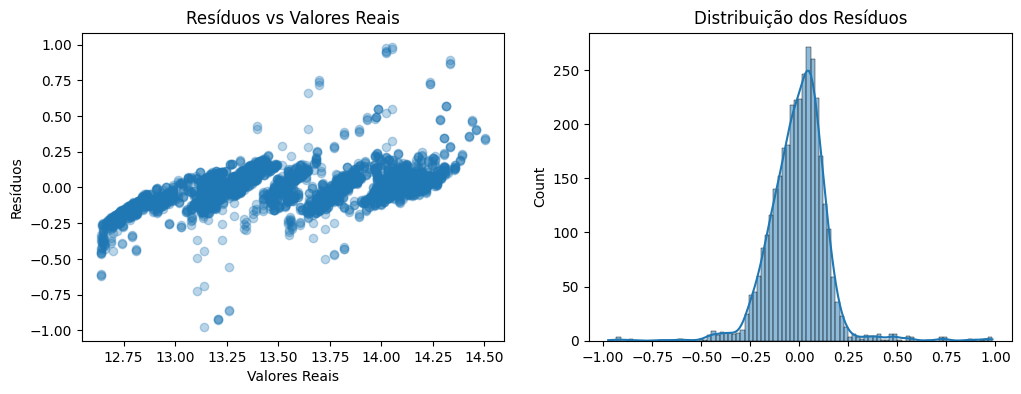

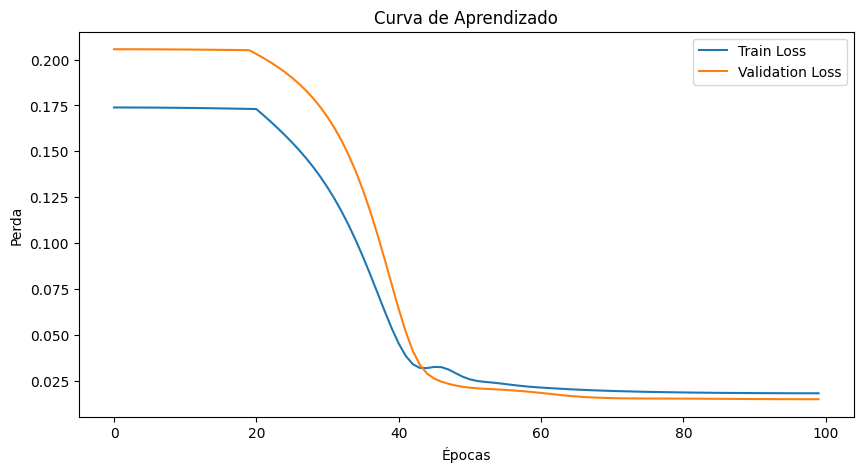

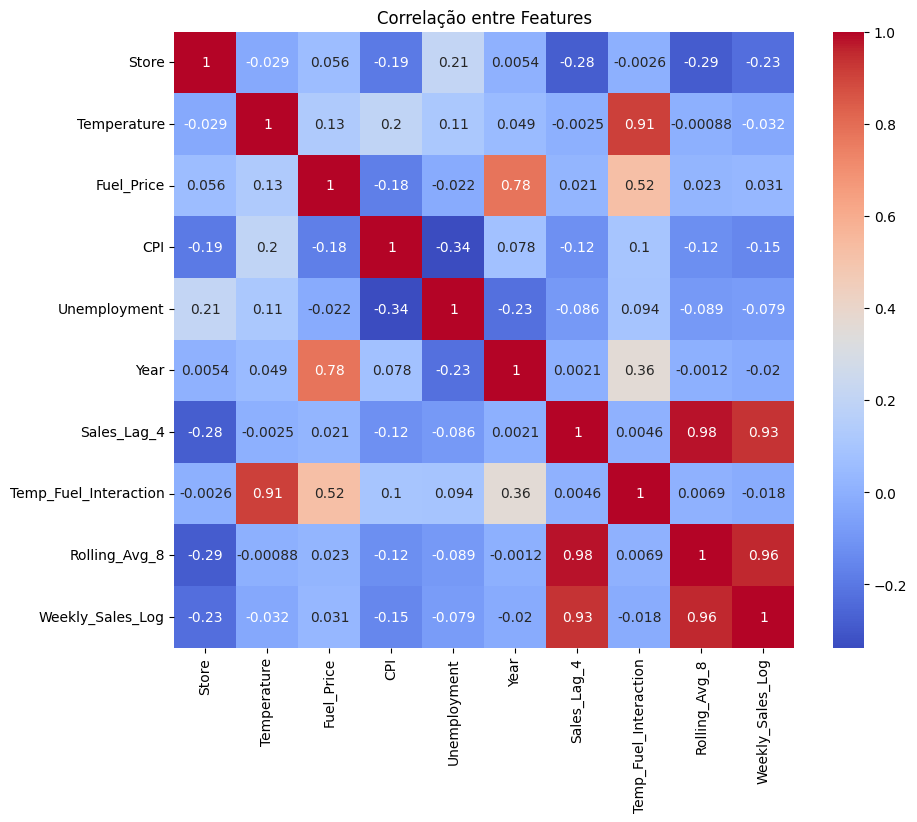

In [15]:
# 6. Verificações Adicionais
# Análise de resíduos
residuals = y_true - y_pred

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(y_true, residuals, alpha=0.3)
plt.title('Resíduos vs Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Resíduos')

plt.subplot(122)
sns.histplot(residuals.flatten(), kde=True)
plt.title('Distribuição dos Resíduos')
plt.show()

# Curva de aprendizado
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Curva de Aprendizado')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Correlação entre features
plt.figure(figsize=(10,8))
sns.heatmap(df[selected_features + [target]].corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre Features')
plt.show()